# Linear Regression을 이용한 앙상블 알고리즘 만들기

In [13]:
import numpy as np
import random

## 클래스 생성

### LRModel
- 경사 하강법을 이용한 단순선형회귀분석
- Score에는 결정계수 이용

In [14]:
class LRModel:
    #초기화 작업
    def __init__(self):
        self.w=1.0 #가중치 초기화
        self.b=1.0 #절편 초기화
    
    #정방향 계산
    def forpass(self, x):
        y_hat=x*self.w+self.b #직선의 방정식 계산
        return y_hat
    
    #역방향 계산
    def backprop(self,x,err):
        w_grad=x*err #가중치에 대한 그래디언트 계산
        b_grad=1*err #절편에 대한 그래디언트 계산
        return w_grad,b_grad
    
    #훈련
    def fit(self,x,y,epoch=100): #w, b는 처음에만 1로 초기화되고 epoch의 크기에 따라 변화
        for _ in range(epoch):
            for x_i,y_i in zip(x,y):
                y_hat=self.forpass(x_i)
                err=(y_i-y_hat)
                w_grad,b_grad=self.backprop(x_i,err)
                self.w+=w_grad
                self.b+=b_grad
        return self.w,self.b
    
    #평가 지표 출력
    def score(self,x,y):
        y_hat_list=[x_val*self.w+self.b for x_val in x]
        y_mean=np.mean(y)
        sst=np.sum([(y_val-y_mean)**2 for y_val in y])
        ssr=np.sum([(y_hat-y_mean)**2 for y_hat in y_hat_list])
        r_squared=ssr/sst #결정계수
        return r_squared

### LRForest
- 위의 LRModel을 이용한 앙상블 학습
- 앙상블 알고리즘은 Random Forest와 동일
- Score에는 결정계수 이용

In [15]:
class LRForest:
    #생성자
    def __init__(self,ntree=100,ratio=0.8,epoch=100):
        self.ntree=ntree
        self.ratio=ratio
        self.epoch=epoch
        self.w=1
        self.b=1
    
    #랜덤 인덱스 생성
    def __makelist(self,len,size):
        rlist=[]
        for _ in range(len):
            rand=random.randrange(size)
            rlist.append(rand)
        return rlist

    #정방향 계산
    def __forpass(self, x):
        y_hat=x*self.w+self.b #직선의 방정식 계산
        return y_hat
    
    #역방향 계산
    def __backprop(self,x,err):
        w_grad=x*err #가중치에 대한 그래디언트 계산
        b_grad=1*err #절편에 대한 그래디언트 계산
        return w_grad,b_grad
    
    #하나의 나무
    def __onefit(self,x,y):
        self.w=1
        self.b=1
        for _ in range(self.epoch):
            for x_i,y_i in zip(x,y):
                y_hat=self.__forpass(x_i)
                err=(y_i-y_hat)
                w_grad,b_grad=self.__backprop(x_i,err)
                self.w+=w_grad
                self.b+=b_grad
        return self.w,self.b

    #여러 번 수행
    def fit(self,x,y):
        w_list=[]
        b_list=[]
        x_reshaped=x.reshape(1,-1)
        y_reshaped=y.reshape(1,-1)
        for _ in range(self.ntree):
            rand_index=self.__makelist(np.floor(self.ratio*x_reshaped.shape[1]).astype(int),x_reshaped.shape[1]) #랜덤으로 인덱스 뽑기
            x_list=x_reshaped[0][rand_index] #Feature에서 랜덤으로 뽑기
            y_list=y_reshaped[0][rand_index] #Target에서 랜덤으로 뽑기
            w_one,b_one=self.__onefit(x_list,y_list) #가중치, 절편 계산
            w_list.append(w_one)
            b_list.append(b_one)
        self.w=np.mean(w_list) #가중치 평균: 아래 식 참조
        self.b=np.mean(b_list) #절편 평균: 아래 식 참조
        return self.w,self.b
    
    #평가 지표 출력
    def score(self,x,y):
        y_hat_list=[x_val*self.w+self.b for x_val in x]
        y_mean=np.mean(y)
        sst=np.sum([(y_val-y_mean)**2 for y_val in y])
        ssr=np.sum([(y_hat-y_mean)**2 for y_hat in y_hat_list])
        r_squared=ssr/sst #결정계수
        return r_squared

$$E(wX+b)=E(w)X+E(b)=XE(w)+b$$

___
## 테스트
- sklearn의 당뇨병 데이터셋으로 테스트

In [21]:
from sklearn.datasets import load_diabetes #bunch class

diabetes=load_diabetes()
x=diabetes.data[:,2]
y=diabetes.target

lrmodel=LRForest()
lrf_w,lrf_b=lrmodel.fit(x,y)
print(lrf_w,lrf_b)
print(lrmodel.score(x,y))

932.4542317091576 151.72306573044355
0.3317597554544981


In [22]:
diabetes=load_diabetes()
x=diabetes.data[:,2]
y=diabetes.target

lrmodel=LRModel()
lr_w,lr_b=lrmodel.fit(x,y)
print(lr_w,lr_b)
print(lrmodel.score(x,y))

913.5973364346786 123.39414383177173
0.457735855131287


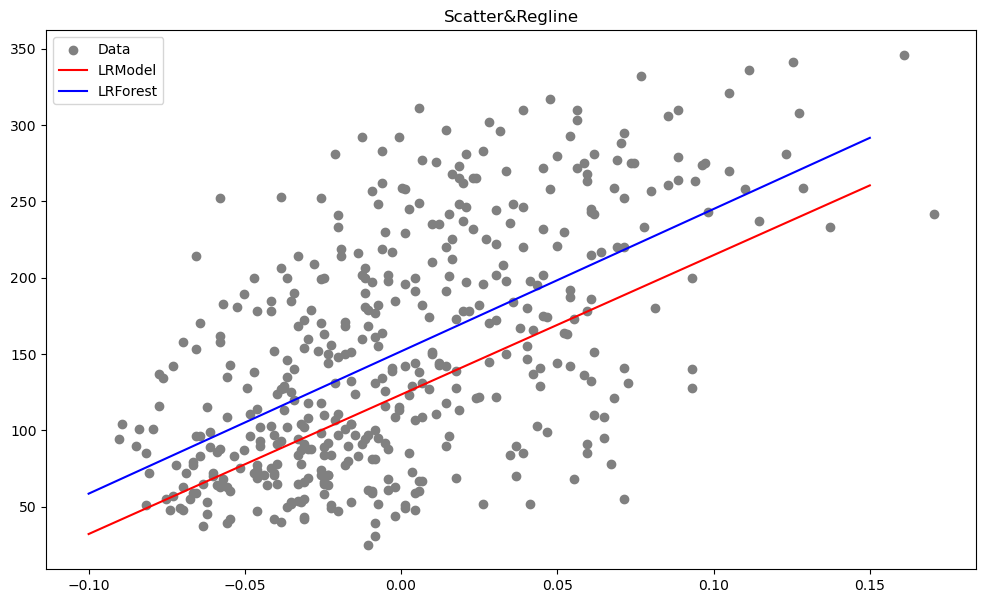

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.scatter(x,y,c='gray')
pt1=(-0.1,-0.1*lr_w+lr_b)
pt2=(0.15,0.15*lr_w+lr_b)
pt3=(-0.1,-0.1*lrf_w+lrf_b)
pt4=(0.15,0.15*lrf_w+lrf_b)
plt.plot([pt1[0],pt2[0]],[pt1[1],pt2[1]],c='red')
plt.plot([pt3[0],pt4[0]],[pt3[1],pt4[1]],c='blue')
plt.title('Scatter&Regline')
plt.legend(['Data','LRModel','LRForest'])
plt.show()

### sklearn의 모델과 비교

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

rf=LinearRegression()
rf.fit(x.reshape(-1,1),y)
print(rf.coef_)
print(rf.intercept_)

[949.43526038]
152.13348416289617


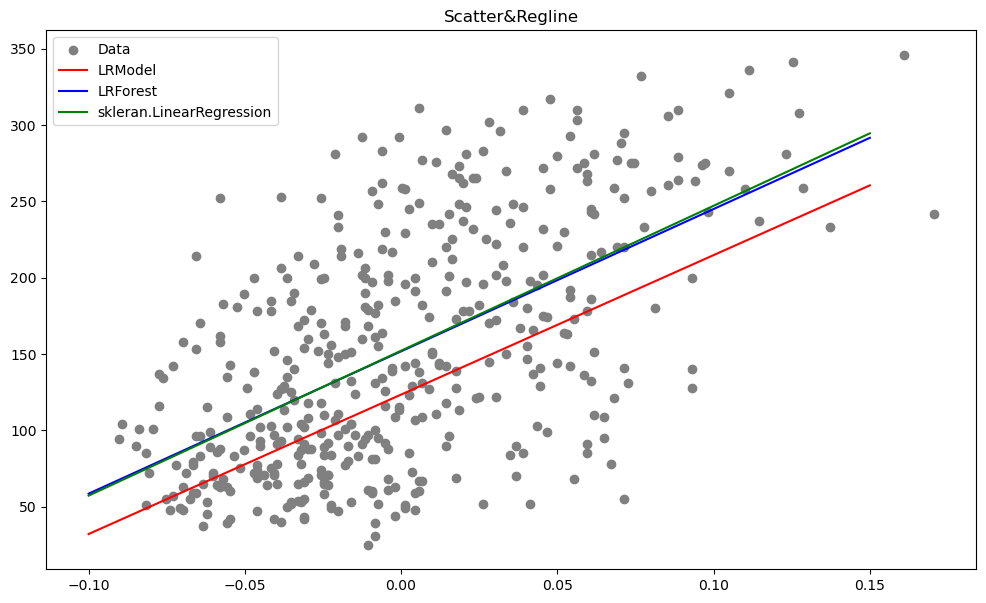

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,7))
plt.scatter(x,y,c='gray')
pt1=(-0.1,-0.1*lr_w+lr_b)
pt2=(0.15,0.15*lr_w+lr_b)
pt3=(-0.1,-0.1*lrf_w+lrf_b)
pt4=(0.15,0.15*lrf_w+lrf_b)
pt5=(-0.1,-0.1*rf.coef_[0]+rf.intercept_)
pt6=(0.15,0.15*rf.coef_[0]+rf.intercept_)
plt.plot([pt1[0],pt2[0]],[pt1[1],pt2[1]],c='red')
plt.plot([pt3[0],pt4[0]],[pt3[1],pt4[1]],c='blue')
plt.plot([pt5[0],pt6[0]],[pt5[1],pt6[1]],c='green')
plt.title('Scatter&Regline')
plt.legend(['Data','LRModel','LRForest','skleran.LinearRegression'])
plt.show()